In [3]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from scipy.stats import norm
from datetime import datetime, timedelta

# Create function for simulating saving for n years

In [4]:
def save_for_n_years_df(df, start_date, end_date, dca_monthly_investment_amount, dca_investment_frequency_per_month):
    
    df = df[df['Date'] < end_date]
    df = df[df['Date'] >= start_date]
    df = df.set_index(pd.DatetimeIndex(df['Date'])).resample(f"{floor(30 / dca_investment_frequency_per_month)}D").agg('first')
    period_last_open = df.iloc[-1]['Open']
    df['added_capital'] = dca_monthly_investment_amount / dca_investment_frequency_per_month
    df['value_period_end'] = df['added_capital'] * (period_last_open / df['Open'])
    return {"start_date": df.iloc[0]['Date'], "end_date": df.iloc[-1]['Date'], "investment_frequency": floor(30 / dca_investment_frequency_per_month), "value": df['value_period_end'].sum()}

# Set simulation parameters

In [18]:
#From what date we will start run our simulations
simulation_start_date = datetime(1927, 12, 30)

#Until what date we will run our simulations
simulation_end_date = datetime(1928, 12, 31)

#What investment frequencies to test - 4/month and 1/month
investment_frequencies_per_month = [4, 2, 1]

#Read file containing S&P500 historical data
file = r'C:\Users\anton\Documents\investment_analysis\data\SPX.csv'
df = pd.read_csv(file, index_col=None, header=0)

#Date column is String, convert to Python Datetime
df['Date'] = pd.to_datetime(df['Date'])

#Results will go here
result = []

# Start simulation

In [19]:
#Loop through each investment frequency
for investment_frequency_per_month in investment_frequencies_per_month:
    
    #Set current date to our simulation start date
    simulation_current_date = simulation_start_date
    
    print(f"Testing investment frequency of {floor(30 / investment_frequency_per_month)} days")

    #Simulate starting investing
    while simulation_current_date < simulation_end_date:
    
        #Save result - Start date, end date, current frequency and value
        result.append(save_for_n_years_df(df, simulation_current_date, simulation_current_date + timedelta(days=365*25), 10000, investment_frequency_per_month))
    
        #Start simulating from 
        simulation_current_date = simulation_current_date + timedelta(days=1)
    
#Convert results to df
results_df = pd.DataFrame(result)

Testing investment frequency of 7 days
Testing investment frequency of 15 days
Testing investment frequency of 30 days


# Results
<p> These are the results after running a simulation where a person invests n SEK for y years

## Investment frequencies
<p> What is the best frequency for investing your money? Once a month? Twice a month? Or perhaps more seldom? </p>

In [22]:
#Group result by investment frequency
results_df.groupby('investment_frequency').agg({'value' : ['mean', 'min', 'max', 'median']})

value                                          
                              mean           min           max        median
investment_frequency                                                        
7                     6.191325e+06  5.667450e+06  6.683085e+06  6.157920e+06
15                    5.786248e+06  5.298005e+06  6.239944e+06  5.757065e+06
30                    5.791814e+06  5.305179e+06  6.240667e+06  5.766355e+06

### Show the best and worst investment frequencies

In [25]:
#Find the best frequency for investing
results_df.sort_values(by=['value'], inplace=True, ascending=False)
results_df.head()

,start_date,end_date,investment_frequency,value
16,1928-01-16,1953-01-05,7,6.683085e+06
15,1928-01-16,1953-01-05,7,6.683085e+06
17,1928-01-16,1953-01-05,7,6.683085e+06
11,1928-01-10,1952-12-30,7,6.665448e+06
12,1928-01-11,1952-12-31,7,6.656314e+06


In [26]:
#Find the worst frequency for investing
results_df.sort_values(by=['value'], inplace=True, ascending=False)
results_df.tail()

,start_date,end_date,investment_frequency,value
1004,1928-09-25,1953-09-14,30,5.305179e+06
636,1928-09-24,1953-09-14,15,5.299178e+06
635,1928-09-24,1953-09-14,15,5.299178e+06
634,1928-09-24,1953-09-14,15,5.299178e+06
637,1928-09-25,1953-09-14,15,5.298005e+06


### Graphs
<p>Display the data in graphs</p>

#### Histogram with 95% confidence interval for our best investment frequency
<p>The graph below plots the results in our best investment frequency scenario and shows the 95% confidence interval for it - This means that in 95% of cases you can expect to end up with this amount of money after 25 years of saving with the selected investment frequency.</p>

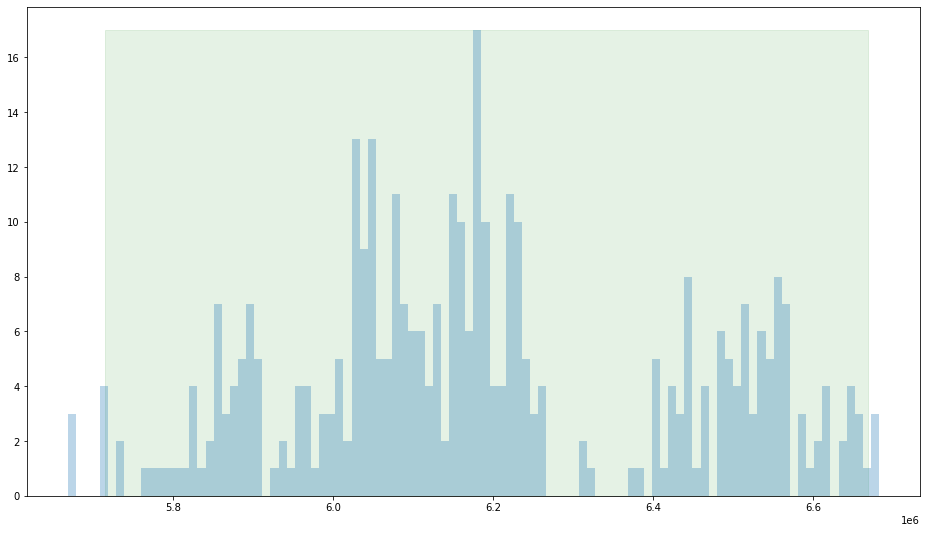

In [11]:
test_df = results_df[results_df['investment_frequency'] == 7]
arr = test_df['value']
plt.figure(figsize=(16,9))
ci = norm(*norm.fit(arr)).interval(0.95)  # fit a normal distribution and get 95% c.i.
height, bins, patches = plt.hist(arr, alpha=0.3, bins=100)
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)

### Combine investment frequency with simulation start dates
<p>Shorter investment frequencies might produce superior results just because they happened to be in a strong bull market (such as 1927, 1997 and 2006). It is possible that this gain would be offset in the aftercoming bust however, but I'm not sure. It would be nice to see if a majority of superior investment frequencies happened to be clustered around certain start dates.</p>

TypeError: cannot unpack non-iterable AxesSubplot object

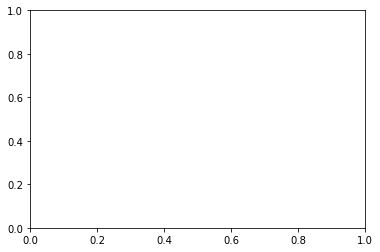

In [37]:
fig, ax = plt.subplot()
for key, grp in results_df.groupby(['investment_frequency']):
    ax = grp.plot(ax=ax, kind='scatter', x='start_date', y='value')
#results_df[results_df['investment_frequency'] == 7].plot.scatter(x = 'start_date', y = 'value')

## What 25-year period produced the best results?
<p>Which 25-year period was the best to be alive and save?</p>

In [12]:
results_df.sort_values(by=['value'], inplace=True, ascending=False)
results_df.tail()

,start_date,end_date,investment_frequency,value
1004,1928-09-25,1953-09-14,30,5.305179e+06
636,1928-09-24,1953-09-14,15,5.299178e+06
635,1928-09-24,1953-09-14,15,5.299178e+06
634,1928-09-24,1953-09-14,15,5.299178e+06
637,1928-09-25,1953-09-14,15,5.298005e+06
